In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')
import pyuvdata
import astropy.units as u
import astropy.coordinates as aco
from matplotlib.colors import LinearSegmentedColormap
import hera_pspec

/lustre/aoc/projects/hera/jaguirre/anaconda3/envs/hera/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Point to your copy of the kohn18_analysis repo
gitpath = '/lustre/aoc/projects/hera/jaguirre/kohn18_analysis/'
rawfile = '/lustre/aoc/projects/hera/pchichur/HERA19/RawData/LSThrs_10.5_23.0/zen.2457548.16700_66112.yy.HH.uvcRP.uvh5'
calfile = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/CalibratedData/LSThrs_10.5_23.0/zen.2457548.16700_66112.yy.HH.uvcRPCS.uvh5'
savepath = gitpath+'FigurePlotting/Plots/'
flagfile = '/lustre/aoc/projects/hera/plaplant/HERA19Golden/CalibratedData/LSThrs_10.5_23.0/zen.2457548_2457555.16700_66112.yy.HH.uvcRPCS.uvh5'

[Text(0,0,'$-\\pi$'),
 Text(0,0,'$-\\pi/2$'),
 Text(0,0,'0'),
 Text(0,0,'$+\\pi$/2'),
 Text(0,0,'$+\\pi$')]

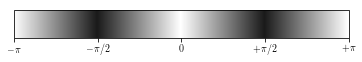

In [3]:
#create cyclic and even colormap
# -pi, -pi/2, 0, pi/2, pi --> white, black, white, black, white
black = (.1, .1, .1)
white = (1, 1, 1)
colors = [white, black, white, black, white]
n_bins = 1000
cmap_name = 'even_cyclic'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

#check that it made what we wanted
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
norm = matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cm,
                                norm=norm,
                                orientation='horizontal',
                                ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cb1.ax.set_xticklabels([r"$-\pi$", r"$-\pi/2$", 0, r"$+\pi$/2", r"$+\pi$"])

In [4]:
%%time
print 'reading raw'
rawuvd = pyuvdata.UVData()
rawuvd.read_uvh5(rawfile)
print 'reading cal'
caluvd = pyuvdata.UVData()
caluvd.read_uvh5(calfile)
#print 'reading flag'
#flaguvd = pyuvdata.UVData()
#flaguvd.read_uvh5(flagfile)
flaguvd=caluvd

reading raw


LSTrng in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types
xants in extra_keywords is a list, array or dict, which will raise an error when writing uvfits or miriad file types


reading cal


In [5]:
lowband = (150, 350)
highband = (530, 730)
flaggeduvd = hera_pspec.flags.construct_factorizable_mask([flaguvd], spw_ranges=[lowband, highband],
                                                          first='row', greedy_threshold=1.e-6)[0]

In [6]:
LSTrads = np.unique(rawuvd.lst_array * u.rad)
LSThrs = aco.Angle(LSTrads).hour
freqs = rawuvd.freq_array[0] / 1e6
extent = [freqs[0], freqs[-1], LSThrs[-1], LSThrs[0]]
bandborders = [150, 350, 530, 730]
freqborders = freqs[bandborders]
print LSThrs
print extent
print freqborders

[10.60083836 10.60382914 10.60681992 ... 22.61780196 22.62079274
 22.62378352]
[100.0, 199.90234375, 22.62378351510091, 10.600838359474938]
[114.6484375 134.1796875 151.7578125 171.2890625]


(687591, 1024)
(687591,)
[2457548.1669994  2457548.1669994  2457548.1669994  ... 2457548.66658761
 2457548.66658761 2457548.66658761]


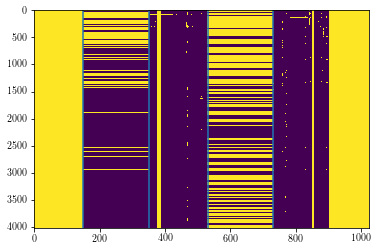

In [7]:
print flaggeduvd.flag_array.squeeze().shape
print flaggeduvd.time_array.shape
print flaggeduvd.time_array
plt.imshow(flaggeduvd.get_flags(9,20,'yy')[0:4021], aspect='auto')
plt.axvline(150)
plt.axvline(350)
plt.axvline(530)
plt.axvline(730)
flags = flaggeduvd.get_flags(9,20,'yy')

1095.5


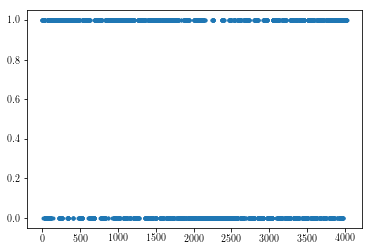

In [8]:
print np.sum(flags[0:4021,600])/2.
plt.plot(flags[0:4021,600], '.')

In [9]:
antpair1 = (88,64)
antpair2 = (97,10)
antpair3 = (20,31)
antpairs = [antpair1, antpair2, antpair3]
band = [110,185]

In [10]:
def get_phs(uvd, antpair, flags):
    phs = np.angle(uvd.get_data(antpair))
    phs *= np.logical_not(flags[:phs.shape[0]])
    return phs

rawphs1 = get_phs(rawuvd, antpair1, flags)
rawphs2 = get_phs(rawuvd, antpair2, flags)
rawphs3 = get_phs(rawuvd, antpair3, flags)
rawphases = [rawphs1, rawphs2, rawphs3]
calphs1 = get_phs(caluvd, antpair1, flags)
calphs2 = get_phs(caluvd, antpair2, flags)
calphs3 = get_phs(caluvd, antpair3, flags)
calphases = [calphs1, calphs2, calphs3]

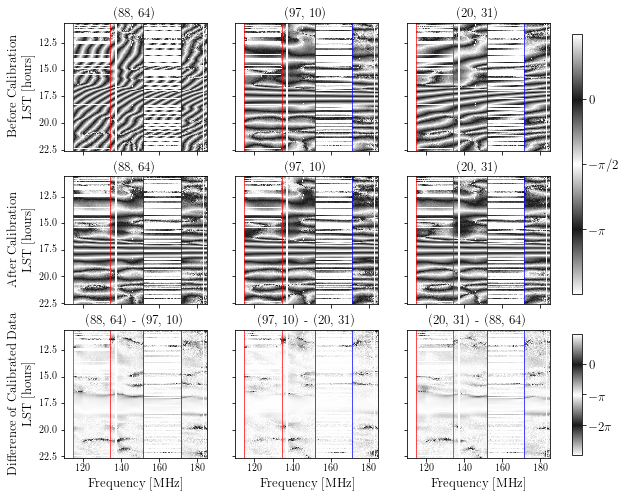

In [11]:
def plot_phs(ax, data, band, antpair, extent, freqlines):
    im = ax.imshow(data, aspect='auto', cmap=cm, extent=extent)
    ax.vlines(freqlines, extent[-1], extent[-2], colors=['r', 'r', 'b', 'b'], linewidth=.7)
    ax.set_title(str(antpair), fontsize=13)
    ax.set_xlim(band)
    return im

def plot_ratio(ax, data1, data2, antpair1, antpair2, extent, freqlines):
    im = ax.imshow(data1-data2, aspect='auto', cmap=cm, extent=extent)
    ax.set_title(str(antpair1) + ' - ' + str(antpair2), fontsize=13)
    ax.set_xlabel('Frequency [MHz]', fontsize=13)
    ax.vlines(freqlines, extent[-1], extent[-2], colors=['r', 'r', 'b', 'b'], linewidth=.7)
    ax.set_xlim(band)
    return im

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,8), sharex=True, sharey='row')
for ax, phsdata, antpair in zip(axes.flatten(), rawphases+calphases, antpairs+antpairs):
    im1 = plot_phs(ax=ax, data=phsdata, band=band, antpair=antpair, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[-1][0], calphs1, calphs2, antpair1, antpair2, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[-1][1], calphs2, calphs3, antpair2, antpair3, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[-1][2], calphs3, calphs1, antpair3, antpair1, extent=extent, freqlines=freqborders)
    
fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.83, 0.41, 0.015, 0.45])
fig.colorbar(im1, cax=cbar_ax1, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar_ax1.set_yticklabels([r"$-\pi$", r"$-\pi/2$", 0, r"$+\pi$/2", r"$+\pi$"], fontsize=13)
cbar_ax2 = fig.add_axes([0.83, 0.13, 0.015, 0.21])
fig.colorbar(im2, cax=cbar_ax2, ticks=[-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
cbar_ax2.set_yticklabels([r"$-2\pi$", r"$-\pi$", 0, r"$+\pi$", r"$+2\pi$"], fontsize=13)

for axs, text in zip(axes, ['Before Calibration', 'After Calibration', 'Difference of Calibrated Data']):
    axs[0].set_ylabel(text + ' \n LST [hours]', fontsize=13)
    
fig.savefig(savepath + 'calibration_on_phases.pdf', bbox_inches='tight')

In [12]:
def get_phs(uvd, antpair):
    phs = np.angle(uvd.get_data(antpair))
    return phs

rawphs1 = get_phs(rawuvd, antpair1)
rawphs2 = get_phs(rawuvd, antpair2)
rawphs3 = get_phs(rawuvd, antpair3)
rawphases = [rawphs1, rawphs2, rawphs3]
calphs1 = get_phs(caluvd, antpair1)
calphs2 = get_phs(caluvd, antpair2)
calphs3 = get_phs(caluvd, antpair3)
calphases = [calphs1, calphs2, calphs3]

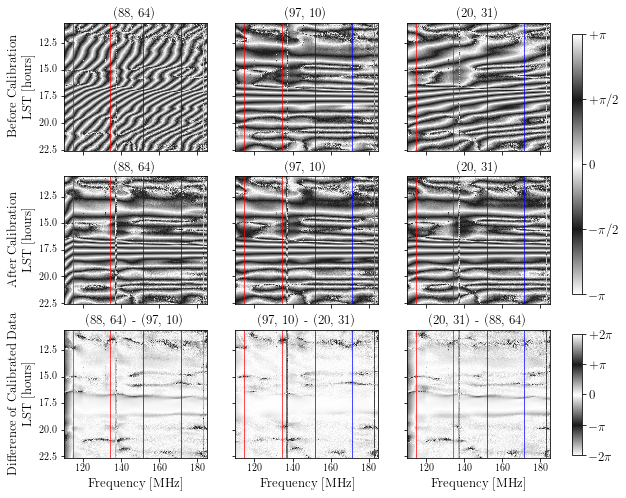

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,8), sharex=True, sharey='row')
for ax, phsdata, antpair in zip(axes.flatten(), rawphases+calphases, antpairs+antpairs):
    im1 = plot_phs(ax=ax, data=phsdata, band=band, antpair=antpair, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[-1][0], calphs1, calphs2, antpair1, antpair2, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[-1][1], calphs2, calphs3, antpair2, antpair3, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[-1][2], calphs3, calphs1, antpair3, antpair1, extent=extent, freqlines=freqborders)
    
fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.83, 0.41, 0.015, 0.45])
fig.colorbar(im1, cax=cbar_ax1, ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar_ax1.set_yticklabels([r"$-\pi$", r"$-\pi/2$", 0, r"$+\pi$/2", r"$+\pi$"], fontsize=13)
cbar_ax2 = fig.add_axes([0.83, 0.13, 0.015, 0.21])
fig.colorbar(im2, cax=cbar_ax2, ticks=[-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
cbar_ax2.set_yticklabels([r"$-2\pi$", r"$-\pi$", 0, r"$+\pi$", r"$+2\pi$"], fontsize=13)

for axs, text in zip(axes, ['Before Calibration', 'After Calibration', 'Difference of Calibrated Data']):
    axs[0].set_ylabel(text + ' \n LST [hours]', fontsize=13)
    
fig.savefig(savepath + 'calibration_on_phases_noflags.pdf', bbox_inches='tight')

In [14]:
from hera_pspec.data import DATA_PATH
import os
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')
cosmo = hera_pspec.conversions.Cosmo_Conversions()
uvb = hera_pspec.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)
Jy_to_mK = uvb.Jy_to_mK(np.unique(caluvd.freq_array), pol='yy')

def get_dataK(uvd, antpair):
    dataK = uvd.get_data(antpair)
    dataK = dataK * Jy_to_mK[None, :]
    return dataK

rawdataK1 = get_dataK(rawuvd, antpair1)
rawdataK2 = get_dataK(rawuvd, antpair2)
rawdataK3 = get_dataK(rawuvd, antpair3)
rawphases = [rawdataK1, rawdataK2, rawdataK3]
caldataK1 = get_dataK(caluvd, antpair1)
caldataK2 = get_dataK(caluvd, antpair2)
caldataK3 = get_dataK(caluvd, antpair3)
calphases = [caldataK1, caldataK2, caldataK3]

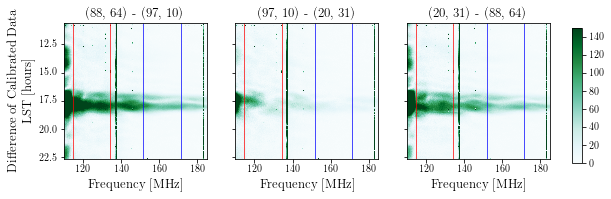

In [15]:
def plot_dataK(ax, data, band, antpair, extent, freqlines):
    im = ax.imshow(np.abs(data), aspect='auto', extent=extent, vmax=8)
    ax.vlines(freqlines, extent[-1], extent[-2], colors=['r', 'r', 'b', 'b'], linewidth=.7)
    ax.set_title(str(antpair), fontsize=13)
    ax.set_xlim(band)
    return im

def plot_ratio(ax, data1, data2, antpair1, antpair2, extent, freqlines):
    im = ax.imshow(np.abs(data1-data2) * 10**-3, aspect='auto', extent=extent, vmax=150, cmap='BuGn')
    ax.set_title(str(antpair1) + ' - ' + str(antpair2), fontsize=13)
    ax.set_xlabel('Frequency [MHz]', fontsize=13)
    ax.vlines(freqlines, extent[-1], extent[-2], colors=['r', 'r', 'b', 'b'], linewidth=.7)
    ax.set_xlim(band)
    return im

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,2.5), sharex=True, sharey='row')
#for ax, dataKdata, antpair in zip(axes.flatten(), rawphases+calphases, antpairs+antpairs):
#    im1 = plot_dataK(ax=ax, data=dataKdata, band=band, antpair=antpair, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[0], caldataK1, caldataK2, antpair1, antpair2, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[1], caldataK2, caldataK3, antpair2, antpair3, extent=extent, freqlines=freqborders)
im2 = plot_ratio(axes[2], caldataK3, caldataK1, antpair3, antpair1, extent=extent, freqlines=freqborders)
    
fig.subplots_adjust(right=0.8)
cbar_ax1 = fig.add_axes([0.83, 0.1, 0.015, 0.75])
fig.colorbar(im2, cax=cbar_ax1)
#cbar_ax1.set_yticklabels([r"$-\pi$", r"$-\pi/2$", 0, r"$+\pi$/2", r"$+\pi$"], fontsize=13)
#cbar_ax2 = fig.add_axes([0.83, 0.13, 0.015, 0.21])
#fig.colorbar(im2, cax=cbar_ax2)
#cbar_ax2.set_yticklabels([r"$-2\pi$", r"$-\pi$", 0, r"$+\pi$", r"$+2\pi$"], fontsize=13)

axes[0].set_ylabel('Difference of Calibrated Data \n LST [hours]', fontsize=13)
    
fig.savefig(savepath + 'calibration_on_vis.pdf', bbox_inches='tight')